## Importing libraries

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
import matplotlib.pyplot as plt
%matplotlib inline 

## Download and Analysis

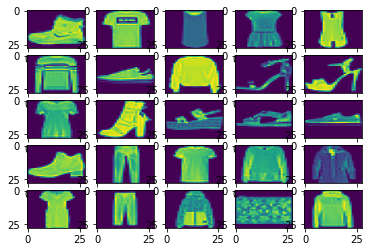

In [2]:
# Loading dataset and splitting into train and test set
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# summarize loaded dataset
# visualize data by plotting images
fig, ax = plt.subplots(5, 5)
k = 0
 
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(X_train[k], aspect='auto')
        k += 1
 
plt.show()


In [3]:
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2
                        "Dress",        # index 3
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6
                        "Sneaker",      # index 7
                        "Bag",          # index 8
                        "Ankle boot"]   # index 9

## Data Preprocessing



Before the training, the data have to be preprocessed. Keras expected input shape is (Number of samples x X-Axis x Y-Axis x Color Channels). Also the RGB coefficients (0-255) values are too high for our model to process (given a typical learning rate), so we target values between 0 and 1. Because the Fashion-MNIST Dataset is not one-hot encoded we need rectify this. 

In [4]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [5]:
# one hot encode target values
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [6]:
# Normalizing the value
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') /255.0


Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

In [7]:
# generating some data and augmenting using ImageGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zca_whitening=True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [8]:
datagen.fit(X_train)

In [9]:
# Model - Building architecture
model = Sequential()
# Add convolution 2D
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same',
                 input_shape=(28, 28, 1))) 
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu',padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same'))
model.add(Conv2D(128, 
                 kernel_size=(3, 3), 
                 padding='same',
                 activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# compiling model 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="Adam",
              metrics=['accuracy'])

As we have multiclass problem we are using categorical crossentropy.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       1

In [11]:

from keras.callbacks import ModelCheckpoint 
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau 

# Training of the model
checkpointer = ModelCheckpoint(filepath='model_best_weights.hdf5', verbose = 1, save_best_only=True) # Model checkpoint to save the best model
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)
# Stopping model if there is no improvement in val loss
earlystop=EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train,
         y_train,
         batch_size=32,
         epochs=25,
         validation_data=(X_test, y_test),
         callbacks=[reduce_lr, earlystop, checkpointer])

Epoch 1/25
1875/1875 [==============================] - 20s 9ms/step - loss: 0.4929 - accuracy: 0.8261 - val_loss: 0.3513 - val_accuracy: 0.8685

Epoch 00001: val_loss improved from inf to 0.35126, saving model to model_best_weights.hdf5
Epoch 2/25
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3236 - accuracy: 0.8827 - val_loss: 0.2965 - val_accuracy: 0.8980

Epoch 00002: val_loss improved from 0.35126 to 0.29650, saving model to model_best_weights.hdf5
Epoch 3/25
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2811 - accuracy: 0.8999 - val_loss: 0.2479 - val_accuracy: 0.9134

Epoch 00003: val_loss improved from 0.29650 to 0.24793, saving model to model_best_weights.hdf5
Epoch 4/25
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2526 - accuracy: 0.9088 - val_loss: 0.2585 - val_accuracy: 0.9090

Epoch 00004: val_loss did not improve from 0.24793
Epoch 5/25
1875/1875 [==============================] - 17s 9ms/step - loss: 0.23

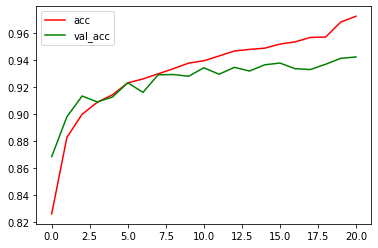

In [12]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc', color='red')
plt.plot(history.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

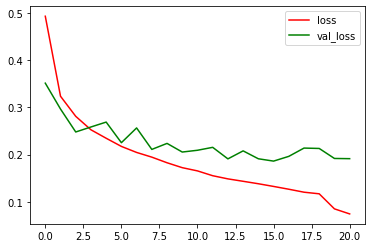

In [13]:
# Plot loss per iteration
plt.plot(history.history['loss'], label='loss', color='red')
plt.plot(history.history['val_loss'], label='val_loss', color='green')
plt.legend()

In [14]:
# Test accuracy
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 94.230



 Test accuracy: 0.9377999901771545


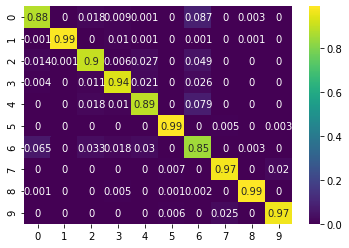

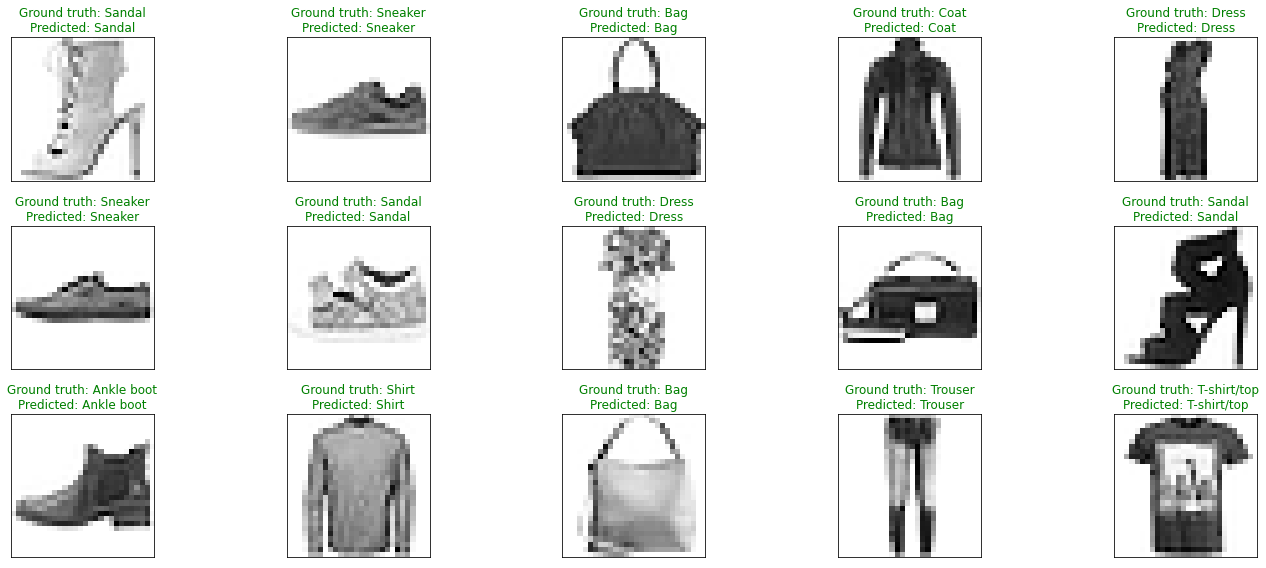

In [15]:
# Load the weights with the best validation accuracy
model.load_weights('model_best_weights.hdf5')

# Evaluate the model on test set
score = model.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])

# Plot Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Get the predictions from the model
y_pred_softmax = model.predict(X_test)
y_pred = np.int32([np.argmax(r) for r in y_pred_softmax])
y_test = np.int32([np.argmax(r) for r in y_test])

# Plot Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)
sn.heatmap(cm, annot=True, cmap='viridis')

# Visualise 15 random test images along with their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]), cmap='Greys')
    predict_index = y_pred[index]
    true_index = y_test[index]
    # Set the title for each image
    ax.set_title("Ground truth: {}\nPredicted: {}".format(fashion_mnist_labels[predict_index],
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.tight_layout()